In [5]:
import dgl
import torch
import numpy as np
import pickle

import matplotlib.pyplot as plt
import networkx as nx

In [121]:
debug = True
# in the learning mode, less nodes are used to better understand the model
if debug:
    node_count = 5
else:# the original data has 34 nodes
    node_count = 34 


In [6]:
# Load from pickle file

with open('edge_list.pickle', 'rb') as f:
    edge_list = pickle.load(f)
    

In [8]:
print(edge_list)
print(type(edge_list))

[('0', '8'), ('1', '17'), ('24', '31'), ('13', '33'), ('0', '1'), ('2', '8'), ('0', '19'), ('25', '31'), ('14', '33'), ('0', '2'), ('2', '9'), ('1', '19'), ('28', '31'), ('15', '33'), ('1', '2'), ('0', '10'), ('0', '21'), ('2', '32'), ('18', '33'), ('0', '3'), ('4', '10'), ('1', '21'), ('8', '32'), ('19', '33'), ('1', '3'), ('5', '10'), ('23', '25'), ('14', '32'), ('20', '33'), ('2', '3'), ('0', '11'), ('24', '25'), ('15', '32'), ('22', '33'), ('0', '4'), ('0', '12'), ('2', '27'), ('18', '32'), ('23', '33'), ('0', '5'), ('3', '12'), ('23', '27'), ('20', '32'), ('26', '33'), ('0', '6'), ('0', '13'), ('24', '27'), ('22', '32'), ('27', '33'), ('4', '6'), ('1', '13'), ('2', '28'), ('23', '32'), ('28', '33'), ('5', '6'), ('2', '13'), ('23', '29'), ('29', '32'), ('29', '33'), ('0', '7'), ('3', '13'), ('26', '29'), ('30', '32'), ('30', '33'), ('1', '7'), ('5', '16'), ('1', '30'), ('31', '32'), ('31', '33'), ('2', '7'), ('6', '16'), ('8', '30'), ('8', '33'), ('32', '33'), ('3', '7'), ('0', '17

In [122]:
def build_karate_club_graph(edges):
    g = dgl.DGLGraph()
    g.add_nodes(node_count)
    edges = [(a,b) for a,b in edges if int(a)<node_count and int(b)<node_count]
    src, dst = tuple(zip(*edges))
    print(src[:10])
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bidirectional
    g.add_edges(dst, src)
    return g

In [123]:
G = build_karate_club_graph(edge_list)
print(G)

('0', '0', '1', '0', '1', '2', '0')
DGLGraph(num_nodes=5, num_edges=14,
         ndata_schemes={}
         edata_schemes={})


In [124]:
#print('We have %d nodes.' % G.number_of_nodes())
#print('We have %d edges.' % G.number_of_edges())
print(f"We have {G.number_of_nodes()} nodes.")
print(f"We have {G.number_of_edges()} edges.")

We have 5 nodes.
We have 14 edges.


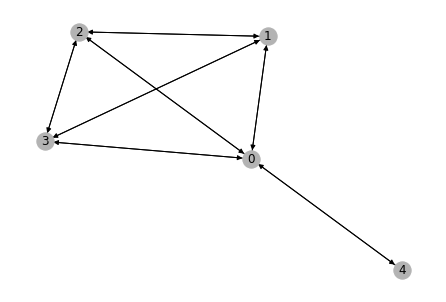

In [129]:
# Since the actual graph is undirected, we convert it for visualization purpose.
#nx_G = G.to_networkx().to_undirected()
nx_G = G.to_networkx()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [140]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message and reduce function
# NOTE: We ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        if debug:
            print('-'*60)
            print(f"g.ndata original it should be the same as input {g.ndata}")
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        if debug:print(f"g.ndata after send {g.ndata}")
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        if debug:print(f"g.ndata after receive{g.ndata}")
        # get the result node features
        h = g.ndata.pop('h')
        if debug:
            print('h in the gnn', h.shape)
            print(h)
        # perform linear transformation
        h = self.linear(h)
        print('after linear', h.shape)
        print(h)
        return h

In [142]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        #print("inputs", inputs.shape)
        #print(inputs)
        h = torch.relu(h)
        print("hidden layer 1", h.shape)
        print(h)
        h = self.gcn2(g, h)
        #print("hiden layer 2 before softmax",h.shape)
        #print(h)
        h = self.softmax(h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
if debug:net = GCN(node_count, 4, 2)
else:net = GCN(node_count, 16, 2)

In [138]:
inputs = torch.eye(node_count)
labeled_nodes = torch.tensor([0, node_count-1])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0,1])  # their labels are different

In [143]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
all_preds = []
epochs = 1
losses = []
for epoch in range(epochs):
    preds = net(G, inputs)
    all_preds.append(preds)
    # we only compute loss for labeled nodes
    loss = F.cross_entropy(preds[labeled_nodes], labels)

    #optimizer.zero_grad() # PyTorch accumulates gradients by default
    loss.backward() 
    optimizer.step()
    losses.append(loss.item())
    #print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))
    print(f"Epoch {epoch} | Loss: {loss.item()}")
#print(losses)

------------------------------------------------------------
g.ndata original it should be the same as input {'h': tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])}
g.ndata after send {'h': tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])}
g.ndata after receive{'h': tensor([[0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 0.],
        [1., 1., 0., 1., 0.],
        [1., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0.]])}
h in the gnn torch.Size([5, 5])
tensor([[0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 0.],
        [1., 1., 0., 1., 0.],
        [1., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0.]])
after linear torch.Size([5, 4])
tensor([[-0.4240, -1.3446,  0.6689, -0.7302],
        [ 0.2422, -1.3842,  0.5222, -0.2569],
        [ 0.1246, -1.1316,  0.0965,  0.2073],
        [ 0.5667, -1.119

<ipython-input-142-dbcd42f26448>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  h = self.softmax(h)


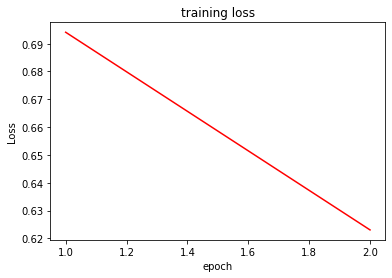

In [73]:
plt.plot(range(1, epochs+1), losses, color='r')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('training loss')
plt.show()

In [132]:
last_epoch = all_preds[epochs-1].detach().numpy()
predicted_class = np.argmax(last_epoch, axis=-1)
color = np.where(predicted_class==0, 'c', 'r')

print(predicted_class)
print(color)

[1 1 1 1 0]
['r' 'r' 'r' 'r' 'c']


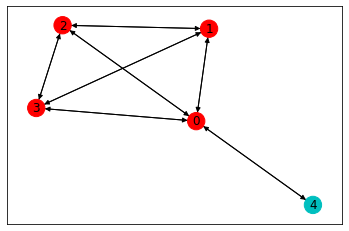

In [133]:
nx.draw_networkx(nx_G, pos, node_color=color, with_labels=True, node_size=300)

In [19]:
print(last_epoch[8])

[9.993837e-01 6.162751e-04]
